### Working process


1)Write a function to extract the tabular information from the given URL under the heading By Market Capitalization, and save it to a data frame.DONE

2)Write a function to transform the data frame by adding columns for Market Capitalization in GBP, EUR, and INR, rounded to 2 decimal places, based on the exchange rate information shared as a CSV file. DONE

3)Write a function to load the transformed data frame to an output CSV file. DONE

4)Write a function to load the transformed data frame to an SQL database server as a table.

5)Write a function to run queries on the database table.

6)Run the following queries on the database table:

    - Extract the information for the London office, that is Name and MC_GBP_Billion
    - Extract the information for the Berlin office, that is Name and MC_EUR_Billion
    - Extract the information for New Delhi office, that is Name and MC_INR_Billion

7)Write a function to log the progress of the code.

8)While executing the data initialization commands and function calls, maintain appropriate log entries.


##### Extract the tabular information from the given URL under the heading By Market Capitalization

In [29]:
#libs
import requests
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime 

In [30]:
#connections

url = 'https://web.archive.org/web/20230908091635%20/https://en.wikipedia.org/wiki/List_of_largest_banks'
database = 'Banks.db'
table_name = 'Largest_banks'
data_path = 'GDPProj/banks_project'
df = pd.DataFrame(columns=['Name','MC_USD_Billion'])
count = 0
log_file = "log_file.txt" 


In [31]:
html_page = requests.get(url).text
soup = BeautifulSoup(html_page, 'html.parser')

# Locate the specific table
table = soup.find("table", {"class": "wikitable sortable"})

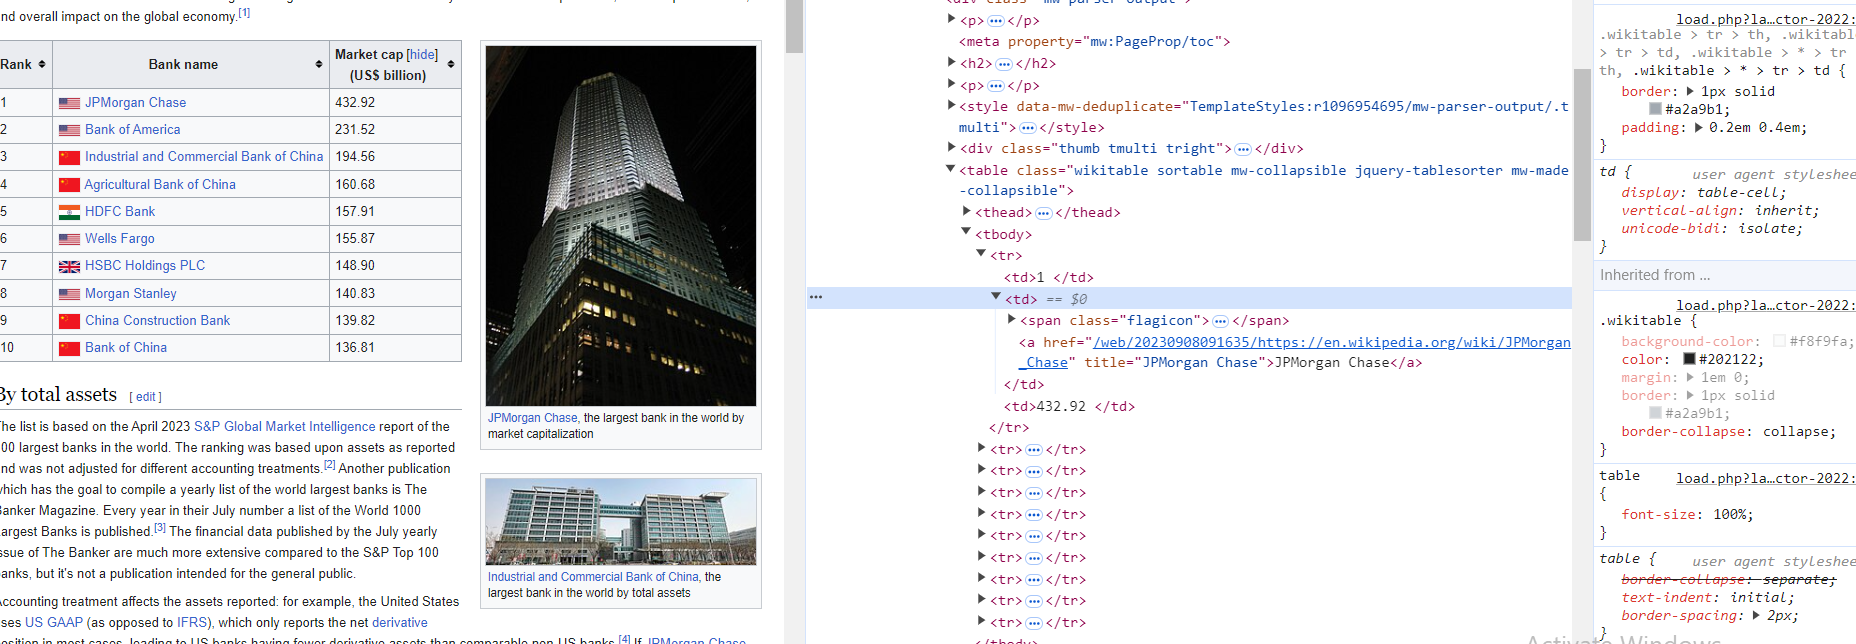

In [32]:
# Print class names of all tables to identify the target table
# this is a test to see home many tasbles athere are and where is the table we are looking for

tables = soup.find_all("table")
for i, table in enumerate(tables):
    print(f"Table {i}: Classes - {table.get('class')}")

    
    
# Attempt to locate the correct table by indexing (assuming it may be the first or second table)

## Based on the output, you may need to adjust the index to target the correct table ##

table = tables[0]  # Change the index based on the output of the above print statements

# After finding out whivj table you need to assign
# you write down the table number ibn the table here!
# very impoetant dont forget


# Verify table selection
print("First few rows of the table:")
for row in table.find("tbody").find_all("tr")[:20]:  # Print first 5 rows to confirm
    print(row)


Table 0: Classes - ['wikitable', 'sortable', 'mw-collapsible']
Table 1: Classes - ['wikitable', 'sortable', 'mw-collapsible']
Table 2: Classes - ['wikitable', 'sortable', 'mw-collapsible']
First few rows of the table:
<tr>
<th data-sort-type="number">Rank
</th>
<th>Bank name
</th>
<th>Market cap<br/>(US$ billion)
</th></tr>
<tr>
<td>1
</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="/web/20230908091635/https://en.wikipedia.org/wiki/United_States" title="United States"><img alt="United States" class="mw-file-element" data-file-height="650" data-file-width="1235" decoding="async" height="12" src="//web.archive.org/web/20230908091635im_/https://upload.wikimedia.org/wikipedia/en/thumb/a/a4/Flag_of_the_United_States.svg/23px-Flag_of_the_United_States.svg.png" srcset="//web.archive.org/web/20230908091635im_/https://upload.wikimedia.org/wikipedia/en/thumb/a/a4/Flag_of_the_United_States.svg/35px-Flag_of_the_United_States.svg.png 1.5x, //web.archive.org/w

In [33]:
# Log the initialization of the ETL process 

def parse_table_to_dataframe(table):

    # Check if the table is found
    if table is None:
        print("Table not found on the page.")
        return pd.DataFrame(columns=['Name', 'MC_USD_Billion'])

    # Initialize an empty DataFrame
    df = pd.DataFrame(columns=['Name', 'MC_USD_Billion'])

    # Iterate through each row in the table body
    for row in table.find("tbody").find_all("tr"):
        col = row.find_all('td')  # Find all columns in the row

        # Ensure that the row has enough columns to avoid empty or irrelevant rows
        if len(col) >= 3:
            # Extract the country name from the first column
            name = col[1].get_text(strip=True)
            
            # Extract the GDP value from the third column, handling commas
            gdp_text = col[2].get_text(strip=True).replace(',', '')

            # Convert GDP to a numeric value if possible
            try:
                gdp = float(gdp_text) if '.' in gdp_text else int(gdp_text)
            except ValueError:
                gdp = None  # Set to None if conversion fails

            # Append the data to the DataFrame
            df = pd.concat([df, pd.DataFrame({'Name': [name], 'MC_USD_Billion': [gdp]})], ignore_index=True)

    return df


In [34]:
df_scraped = parse_table_to_dataframe(table)

C:\Users\jenya\AppData\Local\Temp\ipykernel_21232\1464370100.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Name': [name], 'MC_USD_Billion': [gdp]})], ignore_index=True)


In [35]:
df_scraped

,Name,MC_USD_Billion
0,JPMorgan Chase,432.92
1,Bank of America,231.52
2,Industrial and Commercial Bank of China,194.56
3,Agricultural Bank of China,160.68
4,HDFC Bank,157.91
5,Wells Fargo,155.87
6,HSBC Holdings PLC,148.90
7,Morgan Stanley,140.83
8,China Construction Bank,139.82
9,Bank of China,136.81


In [36]:
# the exchange rates
exchange_rates = pd.read_csv('exchange_rate.csv')

def transform(df, exchange_rates):
    

    # Convert exchange rates to a dictionary for easy lookup
    exchange_dict = exchange_rates.set_index('Currency')['Rate'].to_dict()
    
    # Calculate market cap in different currencies and add to DataFrame
    df_scraped['MC_GBP_Billion'] = (df_scraped['MC_USD_Billion'] * exchange_dict['GBP']).round(2)
    df_scraped['MC_EUR_Billion'] = (df_scraped['MC_USD_Billion'] * exchange_dict['EUR']).round(2)
    df_scraped['MC_INR_Billion'] = (df_scraped['MC_USD_Billion'] * exchange_dict['INR']).round(2)
    
    return df

In [37]:
df_w_currency = transform(df_scraped, exchange_rates)

In [38]:
df_w_currency

,Name,MC_USD_Billion,MC_GBP_Billion,MC_EUR_Billion,MC_INR_Billion
0,JPMorgan Chase,432.92,346.34,402.62,35910.71
1,Bank of America,231.52,185.22,215.31,19204.58
2,Industrial and Commercial Bank of China,194.56,155.65,180.94,16138.75
3,Agricultural Bank of China,160.68,128.54,149.43,13328.41
4,HDFC Bank,157.91,126.33,146.86,13098.63
5,Wells Fargo,155.87,124.70,144.96,12929.42
6,HSBC Holdings PLC,148.90,119.12,138.48,12351.26
7,Morgan Stanley,140.83,112.66,130.97,11681.85
8,China Construction Bank,139.82,111.86,130.03,11598.07
9,Bank of China,136.81,109.45,127.23,11348.39


In [39]:
#As we called it the connections cell.
df_w_currency.to_csv(data_path)

In [40]:
df_w_currency

,Name,MC_USD_Billion,MC_GBP_Billion,MC_EUR_Billion,MC_INR_Billion
0,JPMorgan Chase,432.92,346.34,402.62,35910.71
1,Bank of America,231.52,185.22,215.31,19204.58
2,Industrial and Commercial Bank of China,194.56,155.65,180.94,16138.75
3,Agricultural Bank of China,160.68,128.54,149.43,13328.41
4,HDFC Bank,157.91,126.33,146.86,13098.63
5,Wells Fargo,155.87,124.70,144.96,12929.42
6,HSBC Holdings PLC,148.90,119.12,138.48,12351.26
7,Morgan Stanley,140.83,112.66,130.97,11681.85
8,China Construction Bank,139.82,111.86,130.03,11598.07
9,Bank of China,136.81,109.45,127.23,11348.39


In [41]:
conn = sqlite3.connect(database)

In [42]:
# Load the CSV to the database
df_database = df_w_currency.to_sql(table_name, conn, if_exists = 'replace', index =False)
print('Table is ready')

Table is ready


In [43]:
df_database

10

In [44]:
query_statement = f"SELECT * FROM {table_name}"
query_output = pd.read_sql(query_statement, conn)
print(query_statement)
print(query_output)

SELECT * FROM Largest_banks
                                      Name  MC_USD_Billion  MC_GBP_Billion  \
0                           JPMorgan Chase          432.92          346.34   
1                          Bank of America          231.52          185.22   
2  Industrial and Commercial Bank of China          194.56          155.65   
3               Agricultural Bank of China          160.68          128.54   
4                                HDFC Bank          157.91          126.33   
5                              Wells Fargo          155.87          124.70   
6                        HSBC Holdings PLC          148.90          119.12   
7                           Morgan Stanley          140.83          112.66   
8                  China Construction Bank          139.82          111.86   
9                            Bank of China          136.81          109.45   

   MC_EUR_Billion  MC_INR_Billion  
0          402.62        35910.71  
1          215.31        19204.58  
2    

##### The following queries on the database table

In [45]:
query_statement = f"SELECT Name,MC_GBP_Billion FROM {table_name}"
query_output = pd.read_sql(query_statement, conn)
print(query_statement)
print(query_output)

SELECT Name,MC_GBP_Billion FROM Largest_banks
                                      Name  MC_GBP_Billion
0                           JPMorgan Chase          346.34
1                          Bank of America          185.22
2  Industrial and Commercial Bank of China          155.65
3               Agricultural Bank of China          128.54
4                                HDFC Bank          126.33
5                              Wells Fargo          124.70
6                        HSBC Holdings PLC          119.12
7                           Morgan Stanley          112.66
8                  China Construction Bank          111.86
9                            Bank of China          109.45


In [46]:
query_statement = f"SELECT MC_EUR_Billion FROM {table_name}"
query_output = pd.read_sql(query_statement, conn)
print(query_statement)
print(query_output)

SELECT MC_EUR_Billion FROM Largest_banks
   MC_EUR_Billion
0          402.62
1          215.31
2          180.94
3          149.43
4          146.86
5          144.96
6          138.48
7          130.97
8          130.03
9          127.23


In [47]:
query_statement = f"SELECT Name,MC_INR_Billion FROM {table_name}"
query_output = pd.read_sql(query_statement, conn)
print(query_statement)
print(query_output)

SELECT Name,MC_INR_Billion FROM Largest_banks
                                      Name  MC_INR_Billion
0                           JPMorgan Chase        35910.71
1                          Bank of America        19204.58
2  Industrial and Commercial Bank of China        16138.75
3               Agricultural Bank of China        13328.41
4                                HDFC Bank        13098.63
5                              Wells Fargo        12929.42
6                        HSBC Holdings PLC        12351.26
7                           Morgan Stanley        11681.85
8                  China Construction Bank        11598.07
9                            Bank of China        11348.39


In [48]:
def queires_by_bank_office(df):
    
    query_statement_gbp = f"SELECT Name,MC_GBP_Billion FROM {table_name}"
    query_output_gbp = pd.read_sql(query_statement_gbp, conn)
    print(query_statement_gbp)
    print(query_output_gbp)
    print('------------------------')
    query_statement_eur = f"SELECT Name,MC_EUR_Billion FROM {table_name}"
    query_output_eur = pd.read_sql(query_statement_eur, conn)
    print(query_statement_eur)
    print(query_output_eur)
    print('------------------------')
    query_statement_inr = f"SELECT Name,MC_INR_Billion FROM {table_name}"
    query_output_inr = pd.read_sql(query_statement_inr, conn)
    print(query_statement_inr)
    print(query_output_inr)
    
    return df 

In [49]:
queires_by_bank_office(table_name)

SELECT Name,MC_GBP_Billion FROM Largest_banks
                                      Name  MC_GBP_Billion
0                           JPMorgan Chase          346.34
1                          Bank of America          185.22
2  Industrial and Commercial Bank of China          155.65
3               Agricultural Bank of China          128.54
4                                HDFC Bank          126.33
5                              Wells Fargo          124.70
6                        HSBC Holdings PLC          119.12
7                           Morgan Stanley          112.66
8                  China Construction Bank          111.86
9                            Bank of China          109.45
------------------------
SELECT Name,MC_EUR_Billion FROM Largest_banks
                                      Name  MC_EUR_Billion
0                           JPMorgan Chase          402.62
1                          Bank of America          215.31
2  Industrial and Commercial Bank of China          180.9

'Largest_banks'

In [50]:
# this function will record date and time in the logs
def log_progress(message): 
    timestamp_format = '%Y-%h-%d-%H:%M:%S' # Year-Monthname-Day-Hour-Minute-Second 
    now = datetime.now() # get current timestamp 
    timestamp = now.strftime(timestamp_format) 
    with open(log_file,"a") as f: 
        f.write(timestamp + ',' + message + '\n') 

------------------------------------------------------------

In [51]:
# Log the initialization of the ETL process 
log_progress("ETL Job Started") 


# Log the beginning of the Extraction process 
log_progress("Extract phase Started") 
df_scraped = parse_table_to_dataframe(table)


# Log the completion of the Extraction process 
log_progress("Extract phase Ended") 
df_scraped

# Log the beginning of the Transformation process 
log_progress("Transform phase Started") 
df_w_currency = transform(df_scraped, exchange_rates)


print("Transformed Data") 
print(df_w_currency) 


# Log the completion of the Transformation process 
log_progress("Transform phase Ended") 


# Log the beginning of the Loading process 
log_progress("Load phase Started") 
queires_by_bank_office(table_name)

# Log the completion of the Loading process 
log_progress("Load phase Ended") 

    
# Log the completion of the ETL process 
log_progress("ETL Job Ended") 

Transformed Data
                                      Name  MC_USD_Billion  MC_GBP_Billion  \
0                           JPMorgan Chase          432.92          346.34   
1                          Bank of America          231.52          185.22   
2  Industrial and Commercial Bank of China          194.56          155.65   
3               Agricultural Bank of China          160.68          128.54   
4                                HDFC Bank          157.91          126.33   
5                              Wells Fargo          155.87          124.70   
6                        HSBC Holdings PLC          148.90          119.12   
7                           Morgan Stanley          140.83          112.66   
8                  China Construction Bank          139.82          111.86   
9                            Bank of China          136.81          109.45   

   MC_EUR_Billion  MC_INR_Billion  
0          402.62        35910.71  
1          215.31        19204.58  
2          180.9

C:\Users\jenya\AppData\Local\Temp\ipykernel_21232\1464370100.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'Name': [name], 'MC_USD_Billion': [gdp]})], ignore_index=True)


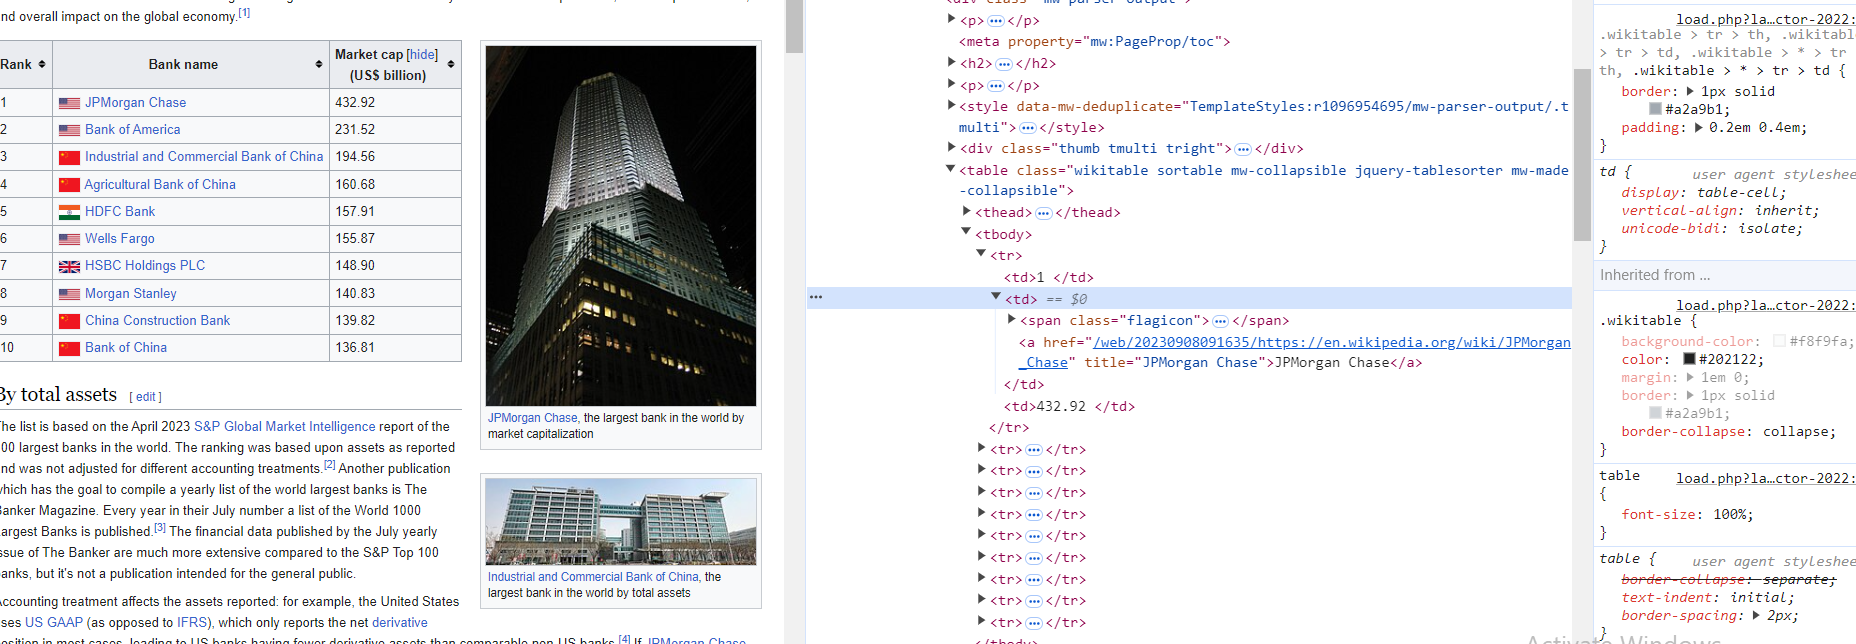

In [52]:
query_statement_gbp = f"SELECT AVG(MC_GBP_Billion) FROM {table_name}"
query_output_gbp = pd.read_sql(query_statement_gbp, conn)
print(query_statement_gbp)
print(query_output_gbp)
print('------------------------')

SELECT AVG(MC_GBP_Billion) FROM Largest_banks
   AVG(MC_GBP_Billion)
0              151.987
------------------------
